## Image Processing

This ipython (sorry, Jupyter) notebook contains the examples that I'll be covering in the 1-dimensional part of my image processing session.  There are no external data files to worry about

### Task 0

Import numpy and matplotlib, and make a simple plot of a sine wave

_N.b._  I usually start with a piece of boilerplate roughly like:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# A nice alternative to inline (which allows interaction with the plots, but can be confusing) is
# %matplotlib notebook

#### Answer 0

In [ ]:
x = np.linspace(0, 10, 100)
y = np.sin(x)

plt.plot(x, y, '-o')
plt.ylim(-1.1, 1.1)
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('My brilliant plot')
plt.show()

### A Toy 1-D Model

We'll make a simple one dimensional model of a star field.  Images of real stars are complicated, but we'll assume that the profile is a Gaussian.  I write a Gaussian with mean $\mu$ and variance $\sigma^2$ as $N(\mu, \sigma^2)$.

Almost all stars are essentially point sources as viewed from the Earth, so stars look like the Point Spread Function (PSF) produced by a combination of the atmosphere, the telescope, and the detector.  There's no standard notation for the PSF, but I always call it $\phi$.  The Full Width Half Maximum (FWHM) is a measure of the PSF's width.

In addition to flux from the stars that we care about there's a smooth background of extra light that comes from a number of sources (atmospheric emission, scattering of star and moonlight, dark current in the detector...); for now we'll just treat this as an annoying constant that I'll call `The Sky'.

In reality CCD data is only measured where we have pixels, but under certain conditions (band-limited; satisfying the Nyquist condition) it turns out that the pixellation is unimportant, so we'll ignore it for this session.

### Task 1

Write a simulator that simulates 1-D data.  Provide a function with signature

    def phi(x, xc=0.0, fwhm=2):
        """Return a numpy array with a star centred at the point xc and FWHM evaluated at the points x"""
        
Use a Gaussian PSF, and set the sky level to S; for a Gaussian $N(0, \beta^2)$, the FWHM is $2\sqrt{2\ln(2)}\,\beta \sim 2.3548\beta$

Plot a few of your beautiful simulations.  Once you've got it working, wrap it up in a function

    simulate(x, S=100)

#### Answer 1

In [ ]:
def phi(x, xc=0.0, FWHM=2):
    beta = FWHM/(2*sqrt(2*log(2)))
    I = np.exp(-0.5*((x - xc)/beta)**2)
    I /= I.sum()
    
    return I
    
x = np.linspace(0, 20, 100, dtype=float)

S = 100

I = S + np.zeros_like(x)
for F, xc in [(500, 7), (2000, 15)]:
    I += F*phi(x, xc)

plt.plot(x, I,'-o')
plt.show()

In [ ]:
def simulate(x, S=100):
    I = S + np.zeros_like(x)
    for F, xc in [(500, 7), (2000, 15)]:
        I += F*phi(x, xc)

    return I

x = np.linspace(0, 20, 100, dtype=float)
I = simulate(x)

plt.plot(x, I,'-o')
plt.show()

### Task 2

There are lots of sources of noise in astronomical data, but for now let's assume that the only thing that matters is the finite number of photons that we detect.  Detecting $n$ photons in a pixel results in a Poisson distribution; if
$n$'s mean value is $\mu$, then its variance is also $\mu$.  If $\mu \gg 1$, $P(\mu) \sim N(\mu, \mu)$.   You can do better than this if you need to;  if $\mu > 4$ (!), Anscombe showed that  $x \equiv 2\sqrt{x + 3/8}$ is approximately Gaussian, $N(2\sqrt{\mu + 3/8} - 1/(4\sqrt\mu), 1)$ -- but you probably only care if you're looking at the tails of the distribution.

Add noise to your simulation.  You can get Poisson variates from numpy by saying _e.g._:

    mu = 100
    print np.random.poisson(lam=mu)
    print np.random.normal(loc=mu, scale=sqrt(mu))    # Here's how to get a Gaussian approximation
    
If you want to set the random number seed so that the noise added is always the same, say something like

    np.random.seed(666)
    
If you can't see your stars you might want to make them brighter --- remember that we added a background noise of 10 when we set the sky level to 100

In [ ]:
mu = 100
print np.random.poisson(lam=mu)
print np.random.normal(loc=mu, scale=sqrt(mu))    # Here's how to get a Gaussian approximation

#### Answer 2

In [ ]:
x = np.linspace(0, 20, 100, dtype=float)
np.random.seed(1000)
sim = simulate(x)
I = np.random.poisson(sim)

plt.plot(x, sim)
plt.errorbar(x, I, I - sim)
plt.show()

### Task 3

Let's investigate measuring the flux in a single isolated star.  Start my modifying your previous two answers to simulate a single star with $\beta = 2$ (a FWHM of c. 5 pixels), centred at x=0, with total flux F0.  In reality estimating the sky background is not trivial, but for now let's simply subtract it.  Plot one of your simulations, with F0=1000 and S=100.

The simplest way to measure the flux in a star is to sum the counts within an aperture.  Modify your code to estimate the flux within $R$ pixels of the centre, then run a Monte-Carlo simulation to estimate the mean and variance of your estimator.

#### Answer 3

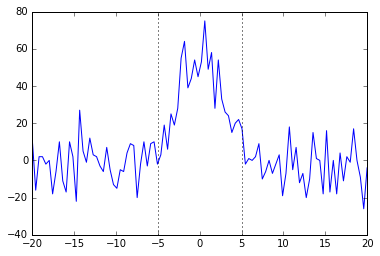

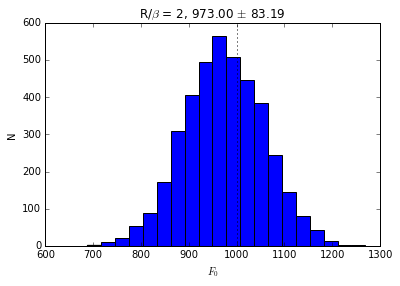

In [9]:
def simulate(x, F0 = 1000, S=100, beta=2.5):
    sim = np.zeros_like(x) + F0*phi(x, FWHM=2*sqrt(2*log(2))*beta)

    return np.random.poisson(sim + S) - S if True else \
           sim + np.random.normal(0, np.sqrt(S + sim)) if False else \
           sim + np.random.normal(0, np.sqrt(S), size=len(sim))

#np.random.seed(1000)    # uncomment to make your noise realisation repeatable

nSample = 4000
flux = np.empty(nSample)
x = np.linspace(-20, 20, 100, dtype=float)

R = 5
beta, F0 = 2.5, 1000
for i in range(nSample):
    sim = simulate(x, F0, beta=beta)
    flux[i] = np.sum(sim[np.abs(x < R)])

plt.plot(x, sim)
for r in (-R, R):
    plt.axvline(r, ls=':', color='black')
plt.show()

plt.hist(flux, 20)
plt.axvline(F0, ls=':', color='black')
plt.xlabel(r"$F_0$")
plt.ylabel("N")
plt.title(r"R/$\beta$ = %g, %.2f $\pm$ %.2f" % (R/beta, np.mean(flux), np.std(flux)))
plt.show()

### Task 4

Package your estimator into a function and estimate the mean and variance as a function of $R$; plot your results.  What value of $R$ gives the smallest variance in $F_0$?

For small $R$ are we measuring $F_0$ correctly?  If not, make appropriate corrections and remake your plots.  Does your conclusion change?